# Getting Started with zipstream-ai

Welcome to **zipstream-ai** - an open-source Python package that simplifies data exploration from compressed archives (ZIP/TAR.GZ) using Large Language Models.

## What does zipstream-ai do?

**zipstream-ai** streamlines the process of:
- **Streaming** compressed files (`.zip`, `.tar.gz`) without extraction
- **Auto-detecting and parsing** various file formats (CSV, JSON, TXT, MD, Parquet)
- **Querying** your data using natural language via LLMs (Gemini or OpenAI GPT)

This package enables quick exploration of datasets stored in compressed archives without manual extraction and format detection.

---

## Installation

Install the required packages using pip:

In [13]:
!pip install zipstream-ai matplotlib seaborn pandas tabulate


---

## Step 1: Create a Demo Dataset and ZIP File

We will create a sample sales dataset with multiple categories and months, then package it into a ZIP file to demonstrate zipstream-ai capabilities.

In [14]:
import pandas as pd
import zipfile
import os
from io import BytesIO
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Create sample sales data
categories = ['Electronics', 'Clothing', 'Home & Garden', 'Books', 'Sports']
months = ['January', 'February', 'March', 'April', 'May', 'June']

data = []
for category in categories:
    for month in months:
        # Generate realistic sales with some variation
        base_sales = np.random.randint(5000, 20000)
        data.append({
            'Category': category,
            'Month': month,
            'Sales': base_sales
        })

df_sales = pd.DataFrame(data)

# Create info.txt file
info_text = """Sales Dataset Information
=====================

This dataset contains monthly sales data across 5 product categories:
- Electronics
- Clothing
- Home & Garden
- Books
- Sports

Data covers 6 months from January to June.
Sales figures are in USD.
"""

# Create ZIP file
with zipfile.ZipFile('demo_data.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add CSV file
    csv_buffer = BytesIO()
    df_sales.to_csv(csv_buffer, index=False)
    zipf.writestr('sales_data.csv', csv_buffer.getvalue())
    
    # Add info text file
    zipf.writestr('info.txt', info_text)

print(" Created demo_data.zip with sales_data.csv and info.txt")
print(f"📊 Dataset shape: {df_sales.shape}")
print("\nPreview of sales data:")
print(df_sales.head(10))

 Created demo_data.zip with sales_data.csv and info.txt
📊 Dataset shape: (30, 3)

Preview of sales data:
      Category     Month  Sales
0  Electronics   January  12270
1  Electronics  February   5860
2  Electronics     March  10390
3  Electronics     April  18418
4  Electronics       May  10191
5  Electronics      June  16964
6     Clothing   January  16284
7     Clothing  February  10734
8     Clothing     March  11265
9     Clothing     April   5466


Now let's visualize the sales share by category using a pie chart:

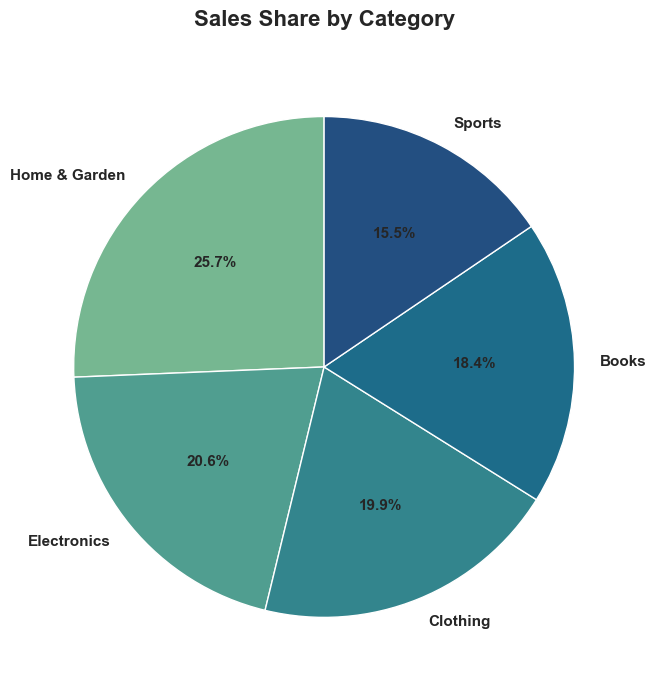


Category Sales Summary:
  Home & Garden: $92,433
  Electronics: $74,093
  Clothing: $71,701
  Books: $66,222
  Sports: $55,906


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Calculate total sales by category
category_totals = df_sales.groupby('Category')['Sales'].sum().sort_values(ascending=False)

# Create pie chart
plt.figure(figsize=(9, 7))
colors = sns.color_palette("crest", len(category_totals))
plt.pie(category_totals.values, 
        labels=category_totals.index, 
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'})
plt.title('Sales Share by Category', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCategory Sales Summary:")
for category, total in category_totals.items():
    print(f"  {category}: ${total:,}")

---

## Step 2: Load and Parse with zipstream-ai

Next, we use **zipstream-ai** to read our compressed archive without extracting it:

In [ ]:
import os
from dotenv import load_dotenv
import google.generativeai as genai

# ============================================
# CRITICAL: Set Gemini API Key FIRST
# ============================================
# This MUST be done before importing any zipstream_ai modules
# because llm_query_engine.py configures the API at import time

# Load environment variables from .env file
load_dotenv()

# Set API key directly
os.environ["GEMINI_API_KEY"] = "<INPUT_YOUR_GEMINI_API_KEY>"

# Configure Google Generative AI immediately
api_key = os.getenv("GEMINI_API_KEY")
if not api_key:
    raise ValueError("GEMINI_API_KEY must be set!")

genai.configure(api_key=api_key)
print(" Gemini API key configured - safe to import zipstream_ai now")

 Gemini API key configured - safe to import zipstream_ai now


In [17]:
from zipstream_ai import ZipStreamReader, FileParser

# Initialize the stream reader
reader = ZipStreamReader("demo_data.zip")

# List all files in the archive
files = reader.list_files()
print(" Files in the archive:")
for file in files:
    print(f"  - {file}")

 Files in the archive:
  - sales_data.csv
  - info.txt


In [18]:
# Parse the CSV file using FileParser
parser = FileParser(reader)
df = parser.load("sales_data.csv")

print(" Successfully loaded sales_data.csv from ZIP file!")
print(f"\nDataset Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print("\n First few rows:")
df.head()

 Successfully loaded sales_data.csv from ZIP file!

Dataset Info:
  Shape: (30, 3)
  Columns: ['Category', 'Month', 'Sales']

 First few rows:


,Category,Month,Sales
0,Electronics,January,12270
1,Electronics,February,5860
2,Electronics,March,10390
3,Electronics,April,18418
4,Electronics,May,10191


In [19]:
# Also read the info.txt file
info_content = parser.load("info.txt")
print(" Contents of info.txt:")
print(info_content)

 Contents of info.txt:
Sales Dataset Information

This dataset contains monthly sales data across 5 product categories:
- Electronics
- Clothing
- Home & Garden
- Books
- Sports

Data covers 6 months from January to June.
Sales figures are in USD.



---

## Step 3: Visualize the Parsed Data

Create a bar plot showing sales trends by category over time:

<Figure size 1400x700 with 0 Axes>

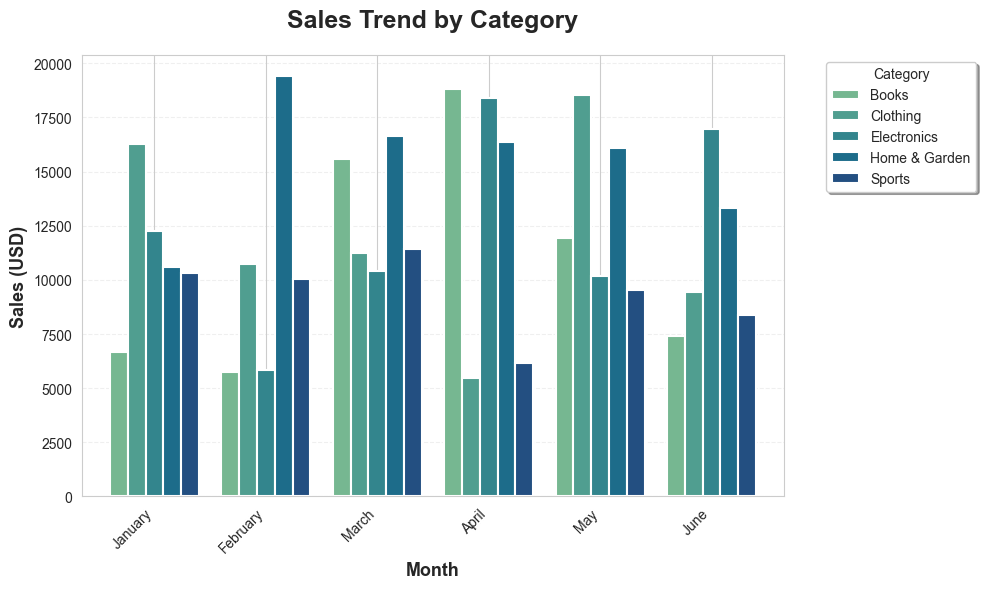


Summary Statistics:
                 sum      mean      std
Category                               
Books          66222  11037.00  5319.57
Clothing       71701  11950.17  4741.06
Electronics    74093  12348.83  4663.45
Home & Garden  92433  15405.50  3056.62
Sports         55906   9317.67  1827.04


In [20]:
# Prepare data for visualization
df_pivot = df.pivot(index='Month', columns='Category', values='Sales')

# Ensure months are in order
month_order = ['January', 'February', 'March', 'April', 'May', 'June']
df_pivot = df_pivot.reindex(month_order)

# Create bar plot
plt.figure(figsize=(14, 7))
ax = df_pivot.plot(kind='bar', 
                   color=sns.color_palette("crest", len(df_pivot.columns)),
                   width=0.8,
                   edgecolor='white',
                   linewidth=1.5)

plt.title('Sales Trend by Category', 
          fontsize=18, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Month', fontsize=13, fontweight='bold')
plt.ylabel('Sales (USD)', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           frameon=True,
           fancybox=True,
           shadow=True)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(df.groupby('Category')['Sales'].agg(['sum', 'mean', 'std']).round(2))

---

In [21]:
# Import ask() function
# Note: API key was already configured in an earlier cell
from zipstream_ai import ask
import zipstream_ai.llm_query_engine as llm_module
import google.generativeai as genai
import os

# Fix: Update model to use an available model
# Available models: gemini-2.5-flash-preview-05-20 or gemini-2.5-pro-preview-03-25
api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=api_key)

# Use one of the available models
available_models = [
    "models/gemini-2.5-flash-preview-05-20",  # Faster, cheaper
    "models/gemini-2.5-pro-preview-03-25",   # More capable
]

# Try to recreate the model with correct name
model_set = False
for model_name in available_models:
    try:
        llm_module.model = genai.GenerativeModel(model_name)
        print(f"Successfully set model to: {model_name}")
        model_set = True
        break
    except Exception as e:
        print(f"Failed to set {model_name}: {str(e)[:80]}")
        continue

if not model_set:
    raise RuntimeError("Could not set any available model. Please check your API access.")

print(" Successfully imported and configured ask() function")

Successfully set model to: models/gemini-2.5-flash-preview-05-20
 Successfully imported and configured ask() function


In [22]:
# Query 1: Which product category has the highest sales?
question1 = "Which product category has the highest sales?"
print(f"Question: {question1}\n")
response1 = ask(df, question1)
print("AI Response:")
print(response1)
print("\n" + "="*70 + "\n")

Question: Which product category has the highest sales?

AI Response:
Based on the data, let's calculate the total sales for each category:

*   **Electronics Total Sales:** 12270 + 5860 + 10390 + 18418 + 10191 + 16964 = **74,093**
*   **Clothing Total Sales:** 16284 + 10734 + 11265 + 5466 = **43,749**

**Electronics** has the highest sales with a total of 74,093.




In [23]:
# Query 2: What's the average sales per month?
question2 = "What is the average sales per month across all categories?"
print(f"Question: {question2}\n")
response2 = ask(df, question2)
print("AI Response:")
print(response2)
print("\n" + "="*70 + "\n")

Question: What is the average sales per month across all categories?

AI Response:
Here are the average sales per month across all categories:

*   **January:** (12270 + 16284) / 2 = **14277**
*   **February:** (5860 + 10734) / 2 = **8297**
*   **March:** (10390 + 11265) / 2 = **10827.5**
*   **April:** (18418 + 5466) / 2 = **11942**
*   **May:** 10191 / 1 = **10191**
*   **June:** 16964 / 1 = **16964**




In [24]:
# Query 3: More complex analysis
question3 = "Which category showed the most growth from January to June? Calculate the percentage change."
print(f"Question: {question3}\n")
response3 = ask(df, question3)
print("AI Response:")
print(response3)

Question: Which category showed the most growth from January to June? Calculate the percentage change.

AI Response:
Based on the provided data:

1.  **Electronics:**
    *   January Sales: 12270
    *   June Sales: 16964
    *   Growth = 16964 - 12270 = 4694
    *   Percentage Change = (4694 / 12270) * 100 = **38.26%**

2.  **Clothing:**
    *   The data for Clothing only extends up to April, so growth from January to June cannot be calculated.

Therefore, among the categories for which the calculation is possible:

**Electronics** showed the most growth from January to June, with a percentage increase of **38.26%**.


---

## Summary

In this tutorial, we have demonstrated how to:

1. **Create and package data** into ZIP archives
2. **Stream and read** files from compressed archives without extraction
3. **Auto-parse** different file formats (CSV, TXT) using `FileParser`
4. **Visualize data** using matplotlib and seaborn
5. **Query data** using natural language with the `ask()` function

### Key Features

- **ZipStreamReader** handles both `.zip` and `.tar.gz` files seamlessly
- **FileParser** automatically detects file formats and delimiters
- **ask()** enables intuitive data exploration through conversational AI